In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [2]:
# data transform
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
class_names

['COVID-19', 'Normal', 'Pnemonia_others', 'non-COVID-19']

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    valid_acc = []
    train_loss = []
    valid_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#            if phase == 'train':
#                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, train_loss, valid_acc, valid_loss

In [7]:
resnext = models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /home/zaghlol/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [8]:
resnext

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [26]:
num_ftrs = resnext.fc.in_features
for param in resnext.parameters():
    param.requires_grad = False
resnext.fc = nn.Linear(num_ftrs, len(class_names))

In [27]:
resnext

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [32]:
for  name, param in resnext.named_parameters():
    print(name,param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [34]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Observe that all parameters are being optimized
optimizer = optim.SGD(resnext.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [35]:
resnext, train_acc, train_loss, valid_acc, valid_loss = train_model(resnext,
                                        criterion, optimizer,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9856 Acc: 0.5789
val Loss: 0.7102 Acc: 0.7226

Epoch 1/24
----------
train Loss: 0.8714 Acc: 0.6357
val Loss: 0.7898 Acc: 0.7051

Epoch 2/24
----------
train Loss: 0.8331 Acc: 0.6482
val Loss: 0.6437 Acc: 0.7503

Epoch 3/24
----------
train Loss: 0.8318 Acc: 0.6521
val Loss: 0.7708 Acc: 0.7205

Epoch 4/24
----------
train Loss: 0.7983 Acc: 0.6742
val Loss: 0.8819 Acc: 0.6918

Epoch 5/24
----------
train Loss: 0.7974 Acc: 0.6692
val Loss: 0.6471 Acc: 0.7513

Epoch 6/24
----------
train Loss: 0.7857 Acc: 0.6783
val Loss: 0.7770 Acc: 0.6759

Epoch 7/24
----------
train Loss: 0.7967 Acc: 0.6662
val Loss: 0.6891 Acc: 0.7285

Epoch 8/24
----------
train Loss: 0.7765 Acc: 0.6833
val Loss: 0.6328 Acc: 0.7556

Epoch 9/24
----------
train Loss: 0.7644 Acc: 0.6831
val Loss: 0.6422 Acc: 0.7412

Epoch 10/24
----------
train Loss: 0.7811 Acc: 0.6822
val Loss: 0.6611 Acc: 0.7450

Epoch 11/24
----------
train Loss: 0.7860 Acc: 0.6758
val Loss: 0.6849 Acc: 0.7434

Ep

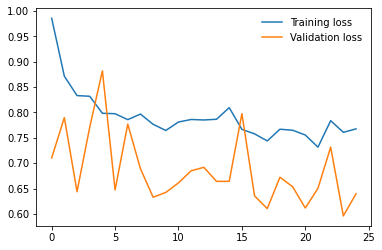

In [36]:
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.show()

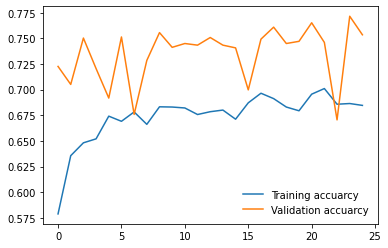

In [37]:
plt.plot(train_acc, label='Training accuarcy')
plt.plot(valid_acc, label='Validation accuarcy')
plt.legend(frameon=False)
plt.show()

In [38]:
predicted = []
labels = []
for data, label in dataloaders["val"]:
    outputs = resnext(data)
    _, preds = torch.max(outputs, 1)
    labels.extend(label.tolist())
    predicted.extend(preds.tolist())
print(len(predicted))
print(len(labels))

1882
1882


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
print(classification_report(labels, predicted, target_names=class_names))
cmf = confusion_matrix(labels,predicted,normalize="true")
cmf = pd.DataFrame(cmf, 
  index = class_names,
  columns = class_names)

                 precision    recall  f1-score   support

       COVID-19       0.73      0.89      0.80       112
         Normal       0.88      0.90      0.89       479
Pnemonia_others       0.69      0.51      0.59       451
   non-COVID-19       0.75      0.82      0.78       840

       accuracy                           0.77      1882
      macro avg       0.76      0.78      0.77      1882
   weighted avg       0.77      0.77      0.77      1882



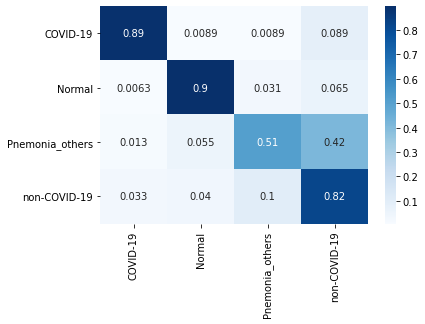

In [44]:
sns.heatmap(cmf, cmap='Blues',annot=True)